# Sentiment Analysis - Wildfires

## Install Libraries

In [4]:
import pandas as pd
import numpy as np
import datetime
import tweepy
import re
import spacy
import glob
import gensim
import gensim.corpora as corpora
import spacy
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import string
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from cleantext import clean

import wordcloud
import matplotlib.pyplot as plt

In [100]:
from itertools import chain

In [3]:

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/su/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/su/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/su/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/su/nltk_data..

True

# API

In [2]:
# Authentication
api_key = "Please insert your key"
api_key_secret = "Please insert your key"
access_key = "Please insert your key"
access_key_secret = "Please insert your key"

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_key, access_key_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

/Users/su/Library/Python/3.8/lib/python/site-packages/tweepy/auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


# Gathering the Data

In [18]:
tweets = tweepy.Cursor(api.search_tweets, q = "wildfire -filter:retweets", lang = "en").items(15000)

In [3]:
%%time
tweet_list = []
tweet_date = []
tweet_rt = []
tweet_fav = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    tweet_date.append(tweet.created_at)
    tweet_rt.append(tweet.retweet_count)
    tweet_fav.append(tweet.favorite_count)
    
wildfire = pd.DataFrame({"tweets": tweet_list, "date": tweet_date, "rt": tweet_rt, "fav": tweet_fav})

NameError: name 'tweets' is not defined

In [ ]:
wildfire.to_csv("wildfire.csv")

# Data

In [5]:
wildfire = pd.read_csv("wildfire.csv")
wildfire.reset_index(drop=True, inplace=True)
wildfire = wildfire.dropna()
wildfire

,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...
...,...,...,...,...,...,...,...
15011,14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0.0,"abl go immedi say media ""russia target civilia..."
15012,14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1.0,devast particular karuk yurok tribe tri protec...
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0.0,ow play wgmu wildfire clean brockhampton best ...
15014,14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6.0,want life reduc bag due wildfire flood would r...


# Data Preprocessing

In [6]:
def remove_text (tweet):
    tweet = re.sub('@[A-Za-z0-9-_]+', '', tweet) #to remove mentions
    tweet = re.sub(r'#', '', tweet) # to remove hashtags
    tweet = re.sub(r'RT[/s]+', '', tweet) # to remove retweets
    return tweet

In [7]:
def remove_links (tweet):
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)# remove hyper links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[links]') # remove links
    return tweet

In [8]:
mywords = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
mystopwords = set(stopwords.words('english'))
mycharacters = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•∑€®₺¥π¨`æ´¬¨∆^∂ßæ≈√∫~µ≤≥÷ƒ@'


In [9]:
def remove_words (tweet):
     tweet = re.sub('['+mycharacters + ']+', ' ', tweet) # remove characters 
     tweet = re.sub('\s+', ' ', tweet)   #remove double spacing
     tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
     return tweet

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
/var/folders/lc/vc91d12j7x7csxcqvv3pnhqc0000gn/T/ipykernel_89607/2643602873.py:3: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet)   #remove double spacing


In [10]:
def clean_tweets(tweet, bigrams=False):
    tweet = tweet.lower() # to make lower case
    tweet = remove_text(tweet)
    tweet = remove_links(tweet)
    tweet = remove_words(tweet)
    tweet = clean(tweet, no_emoji=True)
    tweet_token = [word for word in tweet.split(' ')
                            if word not in mystopwords] # remove stopwords

    tweet_token = [mywords(word) if '#' not in word else word
                        for word in tweet_token] # apply word rooter
    if bigrams:
        tweet_token = tweet_token+[tweet_token[i]+'_'+tweet_token[i+1]
                                            for i in range(len(tweet_token)-1)]
    tweet = ' '.join(tweet_token)
    tweet = re.sub('wildfir', 'wildfire', tweet) #to correct wildfire because of data cleaning
    return tweet

In [11]:
wildfire['clean_tweets'] = wildfire.tweets.apply(clean_tweets)

wildfire

/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
/Users/su/Library/Python/3.8/lib/python/site-packages/cleantext/clean.py:58: DeprecationWarning: invalid escape sequence '\ '
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")


,Unnamed: 0.1,Unnamed: 0,tweets,date,rt,fav,clean_tweets
0,0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0.0,blue mountain wildfire januari
1,1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0.0,flashback august wildfire smoke block sun midd...
2,2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0.0,like wildfire
3,3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0.0,europ blister summer may yet alreadi break rec...
4,4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1.0,pretti seriou wildfire newgal right pembrokesh...
...,...,...,...,...,...,...,...
15011,14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0.0,"abl go immedi say media ""russia target civilia..."
15012,14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1.0,devast particular karuk yurok tribe tri protec...
15013,14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0.0,ow play wgmu wildfire clean brockhampton best ...
15014,14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6.0,want life reduc bag due wildfire flood would r...


# Word Cloud

In [12]:
from wordcloud import WordCloud

In [13]:
text = " ".join(i for i in wildfire["clean_tweets"])
text

'blue mountain wildfire januari flashback august wildfire smoke block sun midday hol portug like wildfire europ blister summer may yet alreadi break record nearli hectar r pretti seriou wildfire newgal right pembrokeshir wale wildfire stormhour thephotohour major wildfire spain forc evacu wildflow wildfire fire spread inland due onshor breez toward hous newgal newgalebeach jame still wear flower europ set record wildfire destruct beauti bottom larg wildfire experienc colorado across west threaten home risk "the overlap wildfire risk poverti concentr insur market get peopl think polici larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu campfir close weekend pack soak water dirt stir stick macron plan hold talk france\' wildfire manag jenni che aug listen articl macron plan hold talk france\' wildfire manag jenni che aug listen articl case commerci log wildfire prone fores

In [14]:
text = text.replace('amp','')
text = text.replace('ew', '')
text = text.replace('via', '')
text = text.replace('lis', '')
text = text.replace('peopl', 'people')
text = text.replace('peoplee', 'people')
text = text.replace('peopleee', 'people')
text = text.replace('peopleeee', 'people')
text = text.replace('peopleeeee', 'people')
text = text.replace('peopleeeeee', 'people')
text = text.replace('peopleeeeeee', 'people')
text = text.replace('franc', 'france')
text = text.replace('battl', 'battle')
text = text.replace('wildfire near', 'near')
text = text.replace('wildfire burn', 'burn')
text = text.replace('wildfire risk', 'risk')
text = text.replace('wildfire season', 'season')
text = text.replace('battlee', 'battle')
text = text.replace('francee', 'france')
text = text.replace('franceeeeeeeee', 'france')
text = text.replace('firefighterer', 'firefighter')
text = text.replace('monster wildfire', 'monster')
text = text.replace('firefighter battlee', 'firefighter battle')
text = text.replace('francee firefighter', 'firefighter')
text = text.replace('firefighterererer battlee', 'firefightererer battle')
text = text.replace('firefighterererererererererer', 'firefighter')
text = text.replace('firefighter battleeeeee', 'battle')
text = text.replace('firefighter battleeee', 'battle')
text = text.replace('firefighter battleee', 'battle')
text = text.replace('firefighter battlee', 'battle')

/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/su/Library/Python/3.8/lib/python/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

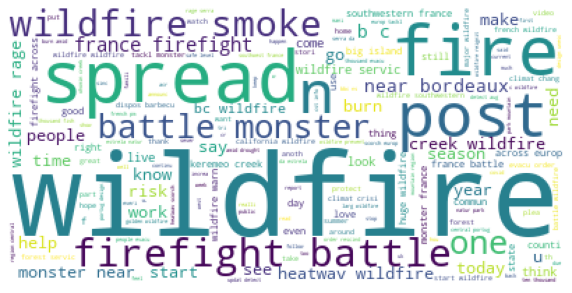

In [15]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
                                                                                                                                                                                                                

# Topic Modelling

Since our data has many unstructured text bodies, we have decieded to use topic modelling to help for for the organization and getting insights from our data.

In [26]:
exlude = set(string.punctuation)
lemma = WordNetLemmatizer()


In [119]:
def separate_tweets(tweet):
    tweet = ''.join(ch for ch in tweet if ch not in exlude)
    tweet = ' '.join([lemma.lemmatize(word) for word in tweet.split()])
    return tweet.split()

In [120]:
wildfire["sep_tweets"] = wildfire["clean_tweets"].apply(separate_tweets)

In [121]:
wildfire["sep_tweets"]

0                      [blue, mountain, wildfire, januari]
1        [flashback, august, wildfire, smoke, block, su...
2                                         [like, wildfire]
3        [europ, blister, summer, may, yet, alreadi, br...
4        [pretti, seriou, wildfire, newgal, right, pemb...
                               ...                        
15011    [abl, go, immedi, say, medium, russia, target,...
15012    [devast, particular, karuk, yurok, tribe, tri,...
15013    [ow, play, wgmu, wildfire, clean, brockhampton...
15014    [want, life, reduc, bag, due, wildfire, flood,...
15015                                           [wildfire]
Name: sep_tweets, Length: 14955, dtype: object

In [122]:
#create dictionary
dictionary = corpora.Dictionary(wildfire["sep_tweets"])
#Total number of non-zeroes in the BOW matrix(sum of the number of unique words per document over the entire corpus)
print(dictionary.num_nnz)

136854


### Create document term matrix

In [123]:
#create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in wildfire["sep_tweets"] ] #bag of words
print(len(doc_term_matrix))

14955


### Instantiate LDA Model

In [124]:
lda = gensim.models.ldamodel.LdaModel

### Fit LDA model to our wildfire dataset

In [125]:
num_topics = 3
%time ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

CPU times: user 48.4 s, sys: 255 ms, total: 48.7 s
Wall time: 48.7 s


### Print the topics identified by LDA model

In [95]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.053*"wildfire" + 0.028*"like" + 0.019*"spread" + 0.014*"post" + 0.005*"one" + 0.005*"go" + 0.005*"start" + 0.004*"n" + 0.004*"get" + 0.004*"know"'),
 (1,
  '0.069*"wildfire" + 0.029*"france" + 0.025*"firefight" + 0.017*"near" + 0.016*"battle" + 0.014*"evacu" + 0.013*"monster" + 0.013*"creek" + 0.011*"heatwav" + 0.011*"thousand"'),
 (2,
  '0.061*"wildfire" + 0.024*"fire" + 0.010*"c" + 0.010*"smoke" + 0.009*"risk" + 0.007*"servic" + 0.007*"burn" + 0.007*"area" + 0.006*"n" + 0.005*"updat"')]

### Visualize the LDA model result

In [118]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/Users/su/Library/Python/3.8/lib/python/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/su/Library/Python/3.8/lib/python/site-